In [60]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
%matplotlib inline
import math
import imblearn
import re
import string
import random
plt.style.use('ggplot')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TextVectorization
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.utils import np_utils

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [5]:
%run feature_extractor.py
from feature_extractor import fingerprint_features

In [6]:
dataset_single = pd.read_csv("D:\\Python\\ML_TEST_SERVIER\\dataset_single.csv")
dataset_multi = pd.read_csv("D:\\Python\\ML_TEST_SERVIER\\dataset_multi.csv")

### Preparing the datasets

In [7]:
dataset_single.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


In [8]:
dataset_multi.head()

,P2,P1,P3,P4,P5,P6,P7,P8,P9,mol_id,smiles
0,1,1,1,1,1,1,1,0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,0,1,1,0,0,0,1,1,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,1,0,1,1,1,1,1,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,1,0,0,1,1,0,1,1,1,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,0,1,1,1,0,1,0,0,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


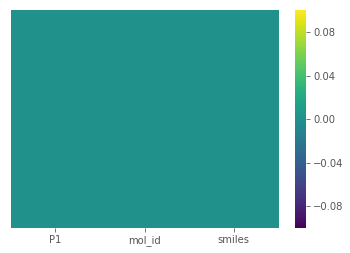

In [9]:
sb.heatmap(dataset_single.isnull(), yticklabels = False, cbar = True,cmap = 'viridis')

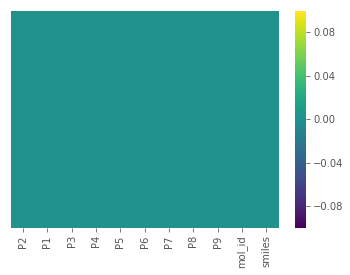

In [10]:
sb.heatmap(dataset_multi.isnull(), yticklabels = False, cbar = True,cmap = 'viridis')

In [11]:
print(dataset_single.nunique())
print(dataset_multi.nunique())

P1           2
mol_id    4999
smiles    4999
dtype: int64
P2           2
P1           2
P3           2
P4           2
P5           2
P6           2
P7           2
P8           2
P9           2
mol_id    4999
smiles    4999
dtype: int64


#### The datasets do not contain any null values. The prediction column for dataset single is binary while that for dataset_multi is a vector of length 9 and each component being binary.

#### Check for imbalance in the predictor column of the datasets.

In [12]:
print(dataset_single['P1'].value_counts())
print(dataset_multi['P1'].value_counts())
print(dataset_multi['P2'].value_counts())
print(dataset_multi['P3'].value_counts())
print(dataset_multi['P4'].value_counts())
print(dataset_multi['P5'].value_counts())
print(dataset_multi['P6'].value_counts())
print(dataset_multi['P7'].value_counts())
print(dataset_multi['P8'].value_counts())
print(dataset_multi['P9'].value_counts())

1    4108
0     891
Name: P1, dtype: int64
1    4108
0     891
Name: P1, dtype: int64
1    4139
0     860
Name: P2, dtype: int64
1    4179
0     820
Name: P3, dtype: int64
1    4151
0     848
Name: P4, dtype: int64
1    4153
0     846
Name: P5, dtype: int64
1    4224
0     775
Name: P6, dtype: int64
1    4196
0     803
Name: P7, dtype: int64
1    4202
0     797
Name: P8, dtype: int64
1    4182
0     817
Name: P9, dtype: int64


#### The prediction column is imbalanced with a distribution of 0 to 1 roughly in the ratio of 1:4. We need to use stratified train_test split everytime we use the original dataset for training.

In [13]:
print(len(fingerprint_features(dataset_single['smiles'][0])))

2048


In [14]:
# Program to check that every molecule has the same number of fingerprint features and the sparsity of the features
for i in range(0,len(dataset_single)):
    if len(fingerprint_features(dataset_single['smiles'][i])) != 2048:
        print(len(fingerprint_features(dataset_single['smiles'][i])))
    else:
        pass

In [15]:
# Program to check the sparsity of the feature vectors
j=0
for i in range(0,len(dataset_single)):
    if np.array(fingerprint_features(dataset_single['smiles'][i])).sum()>100 :
        j=j+1
        print(np.array(fingerprint_features(dataset_single['smiles'][i])).sum())
    else:
        pass
# Each feature vector is sparse as most of the coordinates are 0

#### The sparsity of the feature vectors allow us to do a Principal Component Analysis (PCA)

#### PCA

In [16]:
# Program to convert the features to numpy array for standardization
c=[]
for i in range(0,len(dataset_single)):
    i= np.array(fingerprint_features(dataset_single['smiles'][i]))
    i=np.transpose(i)
    c.append(i)
new_array = np.array(c)  
new_array.shape

(4999, 2048)

In [17]:
Scaled_features = StandardScaler().fit_transform(new_array)

In [18]:
print("The mean is:", np.mean(Scaled_features), " and the variance is:", np.var(Scaled_features))

The mean is: -1.6587273885115299e-19  and the variance is: 0.9999999999999988


In [19]:
#2^11 = 2048, so we project on an 11 dimensional space
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(Scaled_features)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2','principal component 3',
                                      'principal component 4','principal component 5', 'principal component 6',
                                      'principal component 7', 'principal component 8','principal component 9',
                                      'principal component 10','principal component 11'])

#### Partition into prediction and predictor columns

In [20]:
X_init = principalDf
y_single_init = dataset_single['P1']
y_multi_init = dataset_multi[['P1','P2','P3','P4','P5','P6','P7','P8','P9']]

In [21]:
X_single_train, X_single_test, y_single_train, y_single_test = train_test_split(X_init, y_single_init, test_size=0.20, random_state=1, stratify=y_single_init)
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_init, y_multi_init, test_size=0.20, random_state=1)

#### The classical machine learning models

In [22]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 1)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('DT', tree.DecisionTreeClassifier(max_depth=50)))
models.append(('XGB', XGBClassifier()))
models.append(('RF', ensemble.RandomForestClassifier(n_estimators = 40)))

In [23]:
test_set_single_minority = X_single_test.loc[y_single_test.iloc[:] == 0] #Select those rows in X_test which give a 0 value (minority) in y_test

In [24]:
#### Dataset_single
seed = 50
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_single_train, y_single_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    model.fit(X_single_train, y_single_train)
    y_pred = model.predict(X_single_test)
    test_accuracy = accuracy_score(y_single_test, y_pred)*100
    y_pred2 = model.predict(test_set_single_minority)
    special_test_accuracy_0 = accuracy_score(np.zeros(len(test_set_single_minority)), y_pred2)*100
    print(msg)
    print("The test accuracy is:", test_accuracy)
    print("Out of 100 minority values," , special_test_accuracy_0, " were predicted correctly")
    print(y_pred2)
    print("\n")

LR: 0.819945 (0.018176)
The test accuracy is: 82.1
Out of 100 minority values, 2.247191011235955  were predicted correctly
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


LDA: 0.817697 (0.015764)
The test accuracy is: 82.0
Out of 100 minority values, 4.49438202247191  were predicted correctly
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


KNN: 0.741677 (0.020979)
T

In [25]:
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM

##### One class SVM

In [26]:
model = OneClassSVM(gamma='scale', nu=0.00001)
# fit on majority class
trainX = X_single_train[y_single_train==0]
model.fit(trainX)
# detect outliers in the test set
yhat = model.predict(X_single_test)
# mark inliers 1, outliers -1
y_single_test[y_single_test == 0] = -1
y_single_test[y_single_test == 1] = 1
# calculate score
score = f1_score(y_single_test, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.302


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### === The above shows that the classification is poor on the minority classes ===

#### Using Imbalanced Learn

In [27]:
over = RandomOverSampler()
X_single_train_balanced, y_single_train_balanced = over.fit_resample(X_single_train, y_single_train) 

In [28]:
#### Dataset_single_balanced
seed = 50
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_single_train_balanced, y_single_train_balanced, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    model.fit(X_single_train_balanced, y_single_train_balanced)
    y_pred = model.predict(X_single_test)
    test_accuracy = accuracy_score(y_single_test, y_pred)*100
    y_pred2 = model.predict(test_set_single_minority)
    special_test_accuracy_0 = accuracy_score(np.zeros(len(test_set_single_minority)), y_pred2)*100
    print(msg)
    print("The test accuracy is:", test_accuracy)
    print("Out of 100 minority values," , special_test_accuracy_0, " were predicted correctly")
    print(y_pred2)
    print("\n")

LR: 0.631317 (0.011599)
The test accuracy is: 54.7
Out of 100 minority values, 55.61797752808989  were predicted correctly
[0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1
 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1]


LDA: 0.631165 (0.014483)
The test accuracy is: 55.300000000000004
Out of 100 minority values, 54.49438202247191  were predicted correctly
[0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1
 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1]


KNN: 0.9111

#### DNN models

#### Model 1

In [29]:
# baseline model
# We use a single hidden layer with 11 neurons, binary crossentropy loss function and adam optimizer with default learning rate
# of 0.001
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(11, input_shape=(11,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
estimator = KerasClassifier(model=create_baseline(), epochs=10, batch_size=50, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
estimator.fit(X_single_train, y_single_train)
results = cross_val_score(estimator, X_single_train, y_single_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Test accuracy: %.2f%%" %(estimator.score(X_single_test, y_single_test)*100)) 

Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 0.7417 - accuracy: 0.7832
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.8020
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.5257 - accuracy: 0.8105
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.8120
Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.8120
Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4740 - accuracy: 0.8130
Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.8152
Epoch 8/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.8157
Epoch 9/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.8157
Epoch 10/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4560 - accuracy: 0.8160
INFO:tensorflow:Ass

Epoch 5/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.8194
Epoch 6/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4456 - accuracy: 0.8183
Epoch 7/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.8208
Epoch 8/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.8213
Epoch 9/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4423 - accuracy: 0.8211
Epoch 10/10
8/8 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: C:\Users\abiswas\AppData\Local\Temp\tmpoviix25i\assets
Epoch 1/10
72/72 [==============================] - 1s 2ms/step - loss: 0.4527 - accuracy: 0.8191
Epoch 2/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4504 - accuracy: 0.8194
Epoch 3/10
72/72 [==============================] - 0s 2ms/step - loss: 0.4487 - accuracy: 0.8208
Epoch 4/10
72/72 [==============================] - 0s 2ms/step

In [30]:
# baseline model with balanced training set
# We use a single hidden layer with 11 neurons, binary crossentropy loss function and adam optimizer with default learning rate
# of 0.001
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(11, input_shape=(11,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
estimator = KerasClassifier(model=create_baseline(), epochs=10, batch_size=100, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
estimator.fit(X_single_train_balanced, y_single_train_balanced)
results = cross_val_score(estimator, X_single_train_balanced, y_single_train_balanced, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Test accuracy: %.2f%%" %(estimator.score(X_single_test, y_single_test)*100)) 

Epoch 1/10
66/66 [==============================] - 0s 2ms/step - loss: 0.8004 - accuracy: 0.5555
Epoch 2/10
66/66 [==============================] - 0s 2ms/step - loss: 0.7128 - accuracy: 0.5755
Epoch 3/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.6001
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.6105
Epoch 5/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.6170
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.6176
Epoch 7/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.6234
Epoch 8/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6257
Epoch 9/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.6269
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6287
INFO:tensorflow:Ass

Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6367 - accuracy: 0.6382
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6359 - accuracy: 0.6411
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.6421
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.6414
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6335 - accuracy: 0.6394
Epoch 10/10
7/7 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: C:\Users\abiswas\AppData\Local\Temp\tmpz3rii3b3\assets
Epoch 1/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6422 - accuracy: 0.6296
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6347
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.6335
Epoch 4/10
60/60 [==============================] - 0s 2ms/step

In [37]:
# deeper neural network model
def create_deep():
    # create model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(22, input_shape=(11,), activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# evaluate model with standardized dataset and smaller batch size
estimator_deep = KerasClassifier(model=create_deep(), epochs=100, batch_size=10, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
estimator_deep.fit(X_single_train_balanced, y_single_train_balanced)
results = cross_val_score(estimator_deep, X_single_train_balanced, y_single_train_balanced, cv=kfold)
print("Slower learning rate, higher epoch: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Test accuracy: %.2f%%" %(estimator_deep.score(X_single_test, y_single_test)*100)) 

Epoch 1/100
658/658 [==============================] - 2s 2ms/step - loss: 0.6532 - accuracy: 0.6105
Epoch 2/100
658/658 [==============================] - 1s 2ms/step - loss: 0.6294 - accuracy: 0.6417
Epoch 3/100
658/658 [==============================] - 1s 2ms/step - loss: 0.6119 - accuracy: 0.6535
Epoch 4/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5953 - accuracy: 0.6751
Epoch 5/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5800 - accuracy: 0.6867
Epoch 6/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5596 - accuracy: 0.7030
Epoch 7/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5437 - accuracy: 0.7188
Epoch 8/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5268 - accuracy: 0.7273
Epoch 9/100
658/658 [==============================] - 1s 2ms/step - loss: 0.5153 - accuracy: 0.7380
Epoch 10/100
658/658 [==============================] - 1s 2ms/step - loss: 0.4987 - accura

592/592 [==============================] - 1s 2ms/step - loss: 0.1375 - accuracy: 0.9503
Epoch 61/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1480 - accuracy: 0.9469
Epoch 62/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1344 - accuracy: 0.9501
Epoch 63/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1423 - accuracy: 0.9456
Epoch 64/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.9547
Epoch 65/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1469 - accuracy: 0.9459
Epoch 66/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1234 - accuracy: 0.9550
Epoch 67/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1298 - accuracy: 0.9567
Epoch 68/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1238 - accuracy: 0.9542
Epoch 69/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1422 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1578 - accuracy: 0.9401
Epoch 40/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1445 - accuracy: 0.9471
Epoch 41/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1461 - accuracy: 0.9464
Epoch 42/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1432 - accuracy: 0.9462
Epoch 43/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1433 - accuracy: 0.9461
Epoch 44/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1627 - accuracy: 0.9395
Epoch 45/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1545 - accuracy: 0.9430
Epoch 46/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 0.9511
Epoch 47/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1459 - accuracy: 0.9474
Epoch 48/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1505 - accuracy: 

592/592 [==============================] - 2s 3ms/step - loss: 0.1849 - accuracy: 0.9317
Epoch 19/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1574 - accuracy: 0.9423
Epoch 20/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1628 - accuracy: 0.9418
Epoch 21/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1693 - accuracy: 0.9369
Epoch 22/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1577 - accuracy: 0.9403
Epoch 23/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1571 - accuracy: 0.9442
Epoch 24/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1609 - accuracy: 0.9410
Epoch 25/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1584 - accuracy: 0.9400
Epoch 26/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1565 - accuracy: 0.9417
Epoch 27/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1836 - accuracy: 

592/592 [==============================] - 2s 3ms/step - loss: 0.1321 - accuracy: 0.9544
Epoch 78/100
592/592 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.9549
Epoch 79/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1105 - accuracy: 0.9623
Epoch 80/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1322 - accuracy: 0.9532
Epoch 81/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9425
Epoch 82/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1346 - accuracy: 0.9532
Epoch 83/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1276 - accuracy: 0.9533
Epoch 84/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1201 - accuracy: 0.9582
Epoch 85/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1253 - accuracy: 0.9564
Epoch 86/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1310 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1438 - accuracy: 0.9479
Epoch 57/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1472 - accuracy: 0.9440
Epoch 58/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1449 - accuracy: 0.9500
Epoch 59/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1309 - accuracy: 0.9550
Epoch 60/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1458 - accuracy: 0.9496
Epoch 61/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1516 - accuracy: 0.9445
Epoch 62/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1408 - accuracy: 0.9489
Epoch 63/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1440 - accuracy: 0.9469
Epoch 64/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1359 - accuracy: 0.9511
Epoch 65/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1361 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1571 - accuracy: 0.9456
Epoch 36/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9495
Epoch 37/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1450 - accuracy: 0.9461
Epoch 38/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1597 - accuracy: 0.9435
Epoch 39/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1677 - accuracy: 0.9418
Epoch 40/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1394 - accuracy: 0.9518
Epoch 41/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1468 - accuracy: 0.9462
Epoch 42/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1629 - accuracy: 0.9381
Epoch 43/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1537 - accuracy: 0.9420
Epoch 44/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1561 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1660 - accuracy: 0.9422
Epoch 15/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1570 - accuracy: 0.9422
Epoch 16/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1653 - accuracy: 0.9374
Epoch 17/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1511 - accuracy: 0.9456
Epoch 18/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1816 - accuracy: 0.9349
Epoch 19/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1691 - accuracy: 0.9369
Epoch 20/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1511 - accuracy: 0.9451
Epoch 21/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1600 - accuracy: 0.9432
Epoch 22/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1742 - accuracy: 0.9354
Epoch 23/100
592/592 [==============================] - 2s 3ms/step - loss: 0.1704 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1319 - accuracy: 0.9513
Epoch 74/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1232 - accuracy: 0.9537
Epoch 75/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1186 - accuracy: 0.9586
Epoch 76/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1504 - accuracy: 0.9410
Epoch 77/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1122 - accuracy: 0.9586
Epoch 78/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1313 - accuracy: 0.9549
Epoch 79/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1374 - accuracy: 0.9488
Epoch 80/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1080 - accuracy: 0.9621
Epoch 81/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1298 - accuracy: 0.9530
Epoch 82/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1349 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1449 - accuracy: 0.9486
Epoch 53/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1397 - accuracy: 0.9522
Epoch 54/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1530 - accuracy: 0.9454
Epoch 55/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1531 - accuracy: 0.9425
Epoch 56/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1403 - accuracy: 0.9476
Epoch 57/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1482 - accuracy: 0.9457
Epoch 58/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1420 - accuracy: 0.9515
Epoch 59/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1449 - accuracy: 0.9461
Epoch 60/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9457
Epoch 61/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1419 - accuracy: 

592/592 [==============================] - 1s 2ms/step - loss: 0.1596 - accuracy: 0.9437
Epoch 32/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1630 - accuracy: 0.9369
Epoch 33/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1582 - accuracy: 0.9422
Epoch 34/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1490 - accuracy: 0.9466
Epoch 35/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1567 - accuracy: 0.9445
Epoch 36/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1558 - accuracy: 0.9407
Epoch 37/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1396 - accuracy: 0.9467
Epoch 38/100
592/592 [==============================] - 1s 3ms/step - loss: 0.1562 - accuracy: 0.9447
Epoch 39/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1429 - accuracy: 0.9478
Epoch 40/100
592/592 [==============================] - 1s 2ms/step - loss: 0.1512 - accuracy: 

In [38]:
y_pred2 = estimator_deep.predict(test_set_single_minority)
special_test_accuracy_0 = accuracy_score(np.zeros(len(test_set_single_minority)), y_pred2)*100

18/18 [==============================] - 0s 2ms/step


In [39]:
special_test_accuracy_0

23.03370786516854

In [40]:
Model_1 = estimator_deep

In [41]:
tf.keras.models.save_model(Model_1.model, "D:\\Python\\ML_TEST_SERVIER\\Model_1.csv")

INFO:tensorflow:Assets written to: D:\Python\ML_TEST_SERVIER\Model_1.csv\assets


#### Model 2

In [42]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=11, input_type = 'string')
D = dataset_single['smiles']
f = h.transform(D)
f.toarray()

array([[ -6.,  -2., -20., ...,   2.,  -2.,   2.],
       [ -1.,  -1., -16., ...,   2.,  -4.,   0.],
       [ -3.,  -3., -22., ...,   2.,  -6.,   2.],
       ...,
       [ -1.,  -1., -15., ...,   2.,  -2.,   2.],
       [ -1.,   0.,  -8., ...,   2.,  -2.,   0.],
       [  1.,  -3., -14., ...,   2.,  -2.,   2.]])

In [43]:
X_init_model2 = f.toarray()

In [44]:
X_single_train_model2, X_single_test_model2, y_single_train_model2, y_single_test_model2 = train_test_split(X_init_model2, y_single_init, test_size=0.20, random_state=1, stratify=y_single_init)

In [45]:
over = RandomOverSampler()
X_single_train_model2_balanced, y_single_train_model2_balanced = over.fit_resample(X_single_train_model2, y_single_train_model2) 

In [ ]:
X_single_train_model2.shape

In [48]:
# baseline model
# We use a single hidden layer with 11 neurons, binary crossentropy loss function and adam optimizer with default learning rate
# of 0.001
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(11, input_shape=(11,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
estimator_model2 = KerasClassifier(model=create_baseline(), epochs=10, batch_size=100, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
estimator_model2.fit(X_single_train_model2_balanced, y_single_train_model2_balanced)
results = cross_val_score(estimator_model2, X_single_train_model2_balanced, y_single_train_model2_balanced, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Test accuracy: %.2f%%" %(estimator_model2.score(X_single_test_model2, y_single_test_model2)*100)) 

Epoch 1/10
66/66 [==============================] - 1s 2ms/step - loss: 2.0578 - accuracy: 0.4986
Epoch 2/10
66/66 [==============================] - 0s 2ms/step - loss: 0.8070 - accuracy: 0.4910
Epoch 3/10
66/66 [==============================] - 0s 2ms/step - loss: 0.7178 - accuracy: 0.5207
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5622
Epoch 5/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.5994
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6482 - accuracy: 0.6312
Epoch 7/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.6599
Epoch 8/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.6624
Epoch 9/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.6683
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.6643
INFO:tensorflow:Ass

Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6109 - accuracy: 0.6705
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6125 - accuracy: 0.6681
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6715
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6732
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.6739
Epoch 10/10
7/7 [==============================] - 0s 4ms/step
INFO:tensorflow:Assets written to: C:\Users\abiswas\AppData\Local\Temp\tmpasij9kb1\assets
Epoch 1/10
60/60 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.6664
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.6690
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6678
Epoch 4/10
60/60 [==============================] - 0s 2ms/step

In [49]:
y_pred2 = estimator_model2.predict(test_set_single_minority)
special_test_accuracy_0 = accuracy_score(np.zeros(len(test_set_single_minority)), y_pred2)*100
print(special_test_accuracy_0)

2/2 [==============================] - 0s 5ms/step
41.01123595505618


In [50]:
tf.keras.models.save_model(estimator_model2.model, "D:\\Python\\ML_TEST_SERVIER\\my_model2.csv")

INFO:tensorflow:Assets written to: D:\Python\ML_TEST_SERVIER\my_model2.csv\assets


In [51]:
# deeper neural network model, slower learning rate
def create_deep_model2():
    # create model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(22, input_shape=(11,), activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# evaluate model with standardized dataset and smaller batch size
estimator_deep_model2 = KerasClassifier(model=create_deep_model2(), epochs=50, batch_size=50, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
estimator_deep_model2.fit(X_single_train_model2_balanced, y_single_train_model2_balanced)
results = cross_val_score(estimator_deep_model2, X_single_train_model2_balanced, y_single_train_model2_balanced, cv=kfold)
print("Slower learning rate, higher epoch: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Test accuracy: %.2f%%" %(estimator_deep_model2.score(X_single_test_model2, y_single_test_model2)*100)) 

Epoch 1/50
132/132 [==============================] - 1s 2ms/step - loss: 0.6916 - accuracy: 0.5654
Epoch 2/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.6569
Epoch 3/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.6619
Epoch 4/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.6666
Epoch 5/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6107 - accuracy: 0.6744
Epoch 6/50
132/132 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6751
Epoch 7/50
132/132 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6770
Epoch 8/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.6795
Epoch 9/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6044 - accuracy: 0.6738
Epoch 10/50
132/132 [==============================] - 0s 2ms/step - loss: 0.6006 - accuracy: 0.6815

119/119 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7271
Epoch 10/50
119/119 [==============================] - 0s 3ms/step - loss: 0.5092 - accuracy: 0.7302
Epoch 11/50
119/119 [==============================] - 0s 3ms/step - loss: 0.5067 - accuracy: 0.7334
Epoch 12/50
119/119 [==============================] - 0s 3ms/step - loss: 0.5083 - accuracy: 0.7334
Epoch 13/50
119/119 [==============================] - 0s 3ms/step - loss: 0.5102 - accuracy: 0.7298
Epoch 14/50
119/119 [==============================] - 0s 3ms/step - loss: 0.5031 - accuracy: 0.7314
Epoch 15/50
119/119 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.7363
Epoch 16/50
119/119 [==============================] - 0s 2ms/step - loss: 0.5005 - accuracy: 0.7408
Epoch 17/50
119/119 [==============================] - 0s 2ms/step - loss: 0.5041 - accuracy: 0.7359
Epoch 18/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.7395
Ep

119/119 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.7331
Epoch 17/50
119/119 [==============================] - 0s 2ms/step - loss: 0.5050 - accuracy: 0.7376
Epoch 18/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7457
Epoch 19/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4926 - accuracy: 0.7511
Epoch 20/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.7430
Epoch 21/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.7489
Epoch 22/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4901 - accuracy: 0.7467
Epoch 23/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4904 - accuracy: 0.7469
Epoch 24/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7451
Epoch 25/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.7525
Ep

119/119 [==============================] - 0s 2ms/step - loss: 0.4920 - accuracy: 0.7440
Epoch 24/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7495
Epoch 25/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4922 - accuracy: 0.7423
Epoch 26/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4932 - accuracy: 0.7457
Epoch 27/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4879 - accuracy: 0.7462
Epoch 28/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7489
Epoch 29/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4851 - accuracy: 0.7476
Epoch 30/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7500
Epoch 31/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4819 - accuracy: 0.7461
Epoch 32/50
119/119 [==============================] - 0s 2ms/step - loss: 0.4817 - accuracy: 0.7513
Ep

In [56]:
Model_2 = estimator_deep_model2

In [57]:
tf.keras.models.save_model(Model_2.model, "D:\\Python\\ML_TEST_SERVIER\\Model_2.csv")

INFO:tensorflow:Assets written to: D:\Python\ML_TEST_SERVIER\Model_2.csv\assets


#### Model 3

In [58]:
#kernel_initializer='he_uniform',
# get the model
def create_deep_multi(n_inputs, n_outputs):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(22, input_dim=n_inputs, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model

In [61]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = create_deep_multi(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=2, epochs=100, batch_size = 20)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('%.3f' % acc)
        results.append(acc)
    return results
 
# load dataset
X = np.array(X_init)
y = np.array(y_multi_init)
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f Standard Deviation: (%.3f)' % (mean(results), std(results)))

Epoch 1/100
225/225 - 1s - loss: 480.3026 - 699ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 11556.8027 - 326ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 41162.3164 - 313ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 62528.4141 - 339ms/epoch - 2ms/step
Epoch 5/100
225/225 - 0s - loss: 41324.6406 - 286ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 25217.3184 - 324ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 54355.7617 - 297ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 79321.5234 - 274ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 120014.0156 - 329ms/epoch - 1ms/step
Epoch 10/100
225/225 - 0s - loss: 179845.4219 - 358ms/epoch - 2ms/step
Epoch 11/100
225/225 - 0s - loss: 245567.2812 - 278ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 315774.0312 - 264ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 398884.4688 - 269ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 499277.9688 - 342ms/epoch - 2ms/step
Epoch 15/100
225/225 - 0s

Epoch 14/100
225/225 - 0s - loss: 1062695.8750 - 285ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 1336604.2500 - 279ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 1366153.1250 - 259ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1562877.3750 - 272ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 2114009.0000 - 258ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 2734013.0000 - 268ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2853606.7500 - 270ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 3160773.2500 - 278ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 3359173.5000 - 270ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 4137579.0000 - 269ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 4079861.0000 - 285ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 5675610.0000 - 260ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 5402792.5000 - 283ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 6446882.0000 - 272ms/epoch - 1

Epoch 26/100
225/225 - 0s - loss: 2845934.2500 - 290ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 3146337.7500 - 265ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 4009018.0000 - 299ms/epoch - 1ms/step
Epoch 29/100
225/225 - 0s - loss: 4299893.0000 - 275ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 4527988.5000 - 285ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 5293024.5000 - 274ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 5154140.0000 - 261ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 6314055.5000 - 272ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 7217908.5000 - 279ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 7016377.0000 - 269ms/epoch - 1ms/step
Epoch 36/100
225/225 - 0s - loss: 8033818.5000 - 282ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 8506943.0000 - 283ms/epoch - 1ms/step
Epoch 38/100
225/225 - 0s - loss: 8516046.0000 - 282ms/epoch - 1ms/step
Epoch 39/100
225/225 - 0s - loss: 9395190.0000 - 269ms/epoch - 1

Epoch 39/100
225/225 - 0s - loss: 11563672.0000 - 353ms/epoch - 2ms/step
Epoch 40/100
225/225 - 0s - loss: 11574406.0000 - 285ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 13185324.0000 - 263ms/epoch - 1ms/step
Epoch 42/100
225/225 - 0s - loss: 13960168.0000 - 281ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 14735572.0000 - 273ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 15374674.0000 - 269ms/epoch - 1ms/step
Epoch 45/100
225/225 - 0s - loss: 18083088.0000 - 266ms/epoch - 1ms/step
Epoch 46/100
225/225 - 0s - loss: 19342978.0000 - 281ms/epoch - 1ms/step
Epoch 47/100
225/225 - 0s - loss: 20129504.0000 - 285ms/epoch - 1ms/step
Epoch 48/100
225/225 - 0s - loss: 23799182.0000 - 268ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 22698000.0000 - 277ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 23323156.0000 - 284ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 23665444.0000 - 309ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 26088596.0000 - 2

Epoch 51/100
225/225 - 0s - loss: 45432712.0000 - 279ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 49556752.0000 - 275ms/epoch - 1ms/step
Epoch 53/100
225/225 - 0s - loss: 55165508.0000 - 285ms/epoch - 1ms/step
Epoch 54/100
225/225 - 0s - loss: 58724728.0000 - 288ms/epoch - 1ms/step
Epoch 55/100
225/225 - 0s - loss: 55327740.0000 - 273ms/epoch - 1ms/step
Epoch 56/100
225/225 - 0s - loss: 66832720.0000 - 294ms/epoch - 1ms/step
Epoch 57/100
225/225 - 0s - loss: 63836056.0000 - 276ms/epoch - 1ms/step
Epoch 58/100
225/225 - 0s - loss: 66791184.0000 - 285ms/epoch - 1ms/step
Epoch 59/100
225/225 - 0s - loss: 81260968.0000 - 282ms/epoch - 1ms/step
Epoch 60/100
225/225 - 0s - loss: 70410488.0000 - 278ms/epoch - 1ms/step
Epoch 61/100
225/225 - 0s - loss: 74974824.0000 - 275ms/epoch - 1ms/step
Epoch 62/100
225/225 - 0s - loss: 89942416.0000 - 280ms/epoch - 1ms/step
Epoch 63/100
225/225 - 0s - loss: 89721888.0000 - 301ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 91511896.0000 - 2

225/225 - 1s - loss: 33064974.0000 - 543ms/epoch - 2ms/step
Epoch 64/100
225/225 - 0s - loss: 33049408.0000 - 395ms/epoch - 2ms/step
Epoch 65/100
225/225 - 0s - loss: 33639040.0000 - 347ms/epoch - 2ms/step
Epoch 66/100
225/225 - 0s - loss: 39566784.0000 - 354ms/epoch - 2ms/step
Epoch 67/100
225/225 - 0s - loss: 38793628.0000 - 349ms/epoch - 2ms/step
Epoch 68/100
225/225 - 0s - loss: 38494028.0000 - 318ms/epoch - 1ms/step
Epoch 69/100
225/225 - 0s - loss: 41141476.0000 - 335ms/epoch - 1ms/step
Epoch 70/100
225/225 - 0s - loss: 43636340.0000 - 365ms/epoch - 2ms/step
Epoch 71/100
225/225 - 0s - loss: 50062104.0000 - 286ms/epoch - 1ms/step
Epoch 72/100
225/225 - 0s - loss: 44708268.0000 - 265ms/epoch - 1ms/step
Epoch 73/100
225/225 - 0s - loss: 53768460.0000 - 270ms/epoch - 1ms/step
Epoch 74/100
225/225 - 0s - loss: 54777192.0000 - 278ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 57033232.0000 - 272ms/epoch - 1ms/step
Epoch 76/100
225/225 - 0s - loss: 50596596.0000 - 284ms/epoch - 

Epoch 76/100
225/225 - 0s - loss: 122316400.0000 - 269ms/epoch - 1ms/step
Epoch 77/100
225/225 - 0s - loss: 140966864.0000 - 292ms/epoch - 1ms/step
Epoch 78/100
225/225 - 0s - loss: 150023856.0000 - 278ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 158136416.0000 - 271ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 145324944.0000 - 276ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 145574704.0000 - 285ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 159323024.0000 - 284ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 151719728.0000 - 267ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 164075648.0000 - 272ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 180766416.0000 - 295ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 156569056.0000 - 269ms/epoch - 1ms/step
Epoch 87/100
225/225 - 0s - loss: 180934544.0000 - 283ms/epoch - 1ms/step
Epoch 88/100
225/225 - 0s - loss: 166253856.0000 - 264ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 2159

225/225 - 0s - loss: 100198080.0000 - 278ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 100295960.0000 - 270ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 98739624.0000 - 281ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 97036360.0000 - 266ms/epoch - 1ms/step
Epoch 92/100
225/225 - 0s - loss: 107488640.0000 - 272ms/epoch - 1ms/step
Epoch 93/100
225/225 - 0s - loss: 115168184.0000 - 264ms/epoch - 1ms/step
Epoch 94/100
225/225 - 0s - loss: 113709552.0000 - 285ms/epoch - 1ms/step
Epoch 95/100
225/225 - 0s - loss: 139073776.0000 - 267ms/epoch - 1ms/step
Epoch 96/100
225/225 - 0s - loss: 133676136.0000 - 265ms/epoch - 1ms/step
Epoch 97/100
225/225 - 0s - loss: 118797632.0000 - 285ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 119018672.0000 - 268ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 122698392.0000 - 285ms/epoch - 1ms/step
Epoch 100/100
225/225 - 0s - loss: 149226208.0000 - 347ms/epoch - 2ms/step
16/16 [==============================] - 0s 2ms/step

225/225 - 0s - loss: 183417232.0000 - 264ms/epoch - 1ms/step
16/16 [==============================] - 0s 3ms/step
0.286
Epoch 1/100
225/225 - 1s - loss: 1006.5114 - 698ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 18688.0703 - 285ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 44825.8398 - 286ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 45760.7148 - 301ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 20052.5059 - 281ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 49205.2305 - 297ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 80945.9297 - 285ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 135091.2969 - 288ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 206559.2344 - 295ms/epoch - 1ms/step
Epoch 10/100
225/225 - 0s - loss: 253809.8906 - 272ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0s - loss: 402492.2500 - 285ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 472012.8125 - 297ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 701178.1250

Epoch 12/100
225/225 - 0s - loss: 435874.4062 - 278ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 546302.4375 - 286ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 624028.3125 - 267ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 798910.2500 - 280ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 1025854.3125 - 285ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1395654.5000 - 265ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1615485.1250 - 270ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 2002077.7500 - 278ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2102049.2500 - 268ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 2407517.5000 - 281ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 2856597.7500 - 273ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 3441221.2500 - 281ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 3506504.7500 - 266ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 4056682.5000 - 282ms/epoch - 1ms/s

Epoch 25/100
225/225 - 0s - loss: 3739664.7500 - 278ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 3900886.0000 - 334ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 4153263.0000 - 310ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 4873043.5000 - 405ms/epoch - 2ms/step
Epoch 29/100
225/225 - 0s - loss: 5471779.0000 - 425ms/epoch - 2ms/step
Epoch 30/100
225/225 - 0s - loss: 5991041.0000 - 332ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 6274142.5000 - 332ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 7342636.5000 - 322ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 7749930.5000 - 274ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 8701508.0000 - 289ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 9547039.0000 - 339ms/epoch - 2ms/step
Epoch 36/100
225/225 - 0s - loss: 10870667.0000 - 332ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 11027921.0000 - 370ms/epoch - 2ms/step
Epoch 38/100
225/225 - 0s - loss: 11180013.0000 - 383ms/epoch 

225/225 - 0s - loss: 17821518.0000 - 272ms/epoch - 1ms/step
Epoch 38/100
225/225 - 0s - loss: 17569344.0000 - 292ms/epoch - 1ms/step
Epoch 39/100
225/225 - 0s - loss: 18447988.0000 - 274ms/epoch - 1ms/step
Epoch 40/100
225/225 - 0s - loss: 21338484.0000 - 300ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 18816768.0000 - 286ms/epoch - 1ms/step
Epoch 42/100
225/225 - 0s - loss: 22160178.0000 - 281ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 24321118.0000 - 276ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 22782034.0000 - 283ms/epoch - 1ms/step
Epoch 45/100
225/225 - 0s - loss: 26011176.0000 - 273ms/epoch - 1ms/step
Epoch 46/100
225/225 - 0s - loss: 28728298.0000 - 301ms/epoch - 1ms/step
Epoch 47/100
225/225 - 0s - loss: 32046186.0000 - 283ms/epoch - 1ms/step
Epoch 48/100
225/225 - 0s - loss: 31649390.0000 - 269ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 37841812.0000 - 287ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 37835924.0000 - 275ms/epoch - 

225/225 - 0s - loss: 35857676.0000 - 286ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 37482180.0000 - 316ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 36167956.0000 - 284ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 36427788.0000 - 280ms/epoch - 1ms/step
Epoch 53/100
225/225 - 0s - loss: 46517244.0000 - 282ms/epoch - 1ms/step
Epoch 54/100
225/225 - 0s - loss: 42085840.0000 - 287ms/epoch - 1ms/step
Epoch 55/100
225/225 - 0s - loss: 45854808.0000 - 285ms/epoch - 1ms/step
Epoch 56/100
225/225 - 0s - loss: 51790900.0000 - 269ms/epoch - 1ms/step
Epoch 57/100
225/225 - 0s - loss: 52174560.0000 - 297ms/epoch - 1ms/step
Epoch 58/100
225/225 - 0s - loss: 56806640.0000 - 303ms/epoch - 1ms/step
Epoch 59/100
225/225 - 0s - loss: 55409324.0000 - 270ms/epoch - 1ms/step
Epoch 60/100
225/225 - 0s - loss: 50525760.0000 - 311ms/epoch - 1ms/step
Epoch 61/100
225/225 - 0s - loss: 62893612.0000 - 305ms/epoch - 1ms/step
Epoch 62/100
225/225 - 0s - loss: 61830420.0000 - 288ms/epoch - 

Epoch 61/100
225/225 - 0s - loss: 67378680.0000 - 300ms/epoch - 1ms/step
Epoch 62/100
225/225 - 0s - loss: 74737416.0000 - 278ms/epoch - 1ms/step
Epoch 63/100
225/225 - 0s - loss: 74959688.0000 - 287ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 73706248.0000 - 303ms/epoch - 1ms/step
Epoch 65/100
225/225 - 0s - loss: 82898032.0000 - 299ms/epoch - 1ms/step
Epoch 66/100
225/225 - 0s - loss: 96674448.0000 - 313ms/epoch - 1ms/step
Epoch 67/100
225/225 - 0s - loss: 90996312.0000 - 302ms/epoch - 1ms/step
Epoch 68/100
225/225 - 0s - loss: 85644056.0000 - 299ms/epoch - 1ms/step
Epoch 69/100
225/225 - 0s - loss: 113941616.0000 - 284ms/epoch - 1ms/step
Epoch 70/100
225/225 - 0s - loss: 121248736.0000 - 398ms/epoch - 2ms/step
Epoch 71/100
225/225 - 0s - loss: 105999456.0000 - 316ms/epoch - 1ms/step
Epoch 72/100
225/225 - 0s - loss: 121388664.0000 - 300ms/epoch - 1ms/step
Epoch 73/100
225/225 - 0s - loss: 120490064.0000 - 284ms/epoch - 1ms/step
Epoch 74/100
225/225 - 0s - loss: 133378648.00

Epoch 73/100
225/225 - 0s - loss: 56116320.0000 - 311ms/epoch - 1ms/step
Epoch 74/100
225/225 - 0s - loss: 69322616.0000 - 275ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 64296292.0000 - 375ms/epoch - 2ms/step
Epoch 76/100
225/225 - 1s - loss: 62036212.0000 - 533ms/epoch - 2ms/step
Epoch 77/100
225/225 - 0s - loss: 69973872.0000 - 408ms/epoch - 2ms/step
Epoch 78/100
225/225 - 0s - loss: 77535304.0000 - 303ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 75269720.0000 - 328ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 78561264.0000 - 298ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 85454888.0000 - 303ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 76606504.0000 - 292ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 96062648.0000 - 274ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 102829256.0000 - 285ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 96625504.0000 - 296ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 90090008.0000 - 

Epoch 85/100
225/225 - 0s - loss: 153394704.0000 - 283ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 154692208.0000 - 341ms/epoch - 2ms/step
Epoch 87/100
225/225 - 0s - loss: 171812528.0000 - 308ms/epoch - 1ms/step
Epoch 88/100
225/225 - 0s - loss: 179132192.0000 - 291ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 188580496.0000 - 289ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 205742688.0000 - 302ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 179220944.0000 - 380ms/epoch - 2ms/step
Epoch 92/100
225/225 - 0s - loss: 198656640.0000 - 318ms/epoch - 1ms/step
Epoch 93/100
225/225 - 0s - loss: 241328016.0000 - 289ms/epoch - 1ms/step
Epoch 94/100
225/225 - 0s - loss: 236860000.0000 - 297ms/epoch - 1ms/step
Epoch 95/100
225/225 - 0s - loss: 245185696.0000 - 313ms/epoch - 1ms/step
Epoch 96/100
225/225 - 0s - loss: 270096160.0000 - 295ms/epoch - 1ms/step
Epoch 97/100
225/225 - 0s - loss: 228951008.0000 - 296ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 2657

Epoch 97/100
225/225 - 0s - loss: 251334880.0000 - 316ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 266087232.0000 - 312ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 246746672.0000 - 268ms/epoch - 1ms/step
Epoch 100/100
225/225 - 0s - loss: 267995776.0000 - 325ms/epoch - 1ms/step
16/16 [==============================] - 0s 1ms/step
0.308
Epoch 1/100
225/225 - 1s - loss: 536.7134 - 732ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 14855.9824 - 310ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 48046.4531 - 285ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 51207.3398 - 294ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 23667.8164 - 287ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 32099.6836 - 351ms/epoch - 2ms/step
Epoch 7/100
225/225 - 0s - loss: 64861.0625 - 285ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 112026.1562 - 306ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 162379.1094 - 293ms/epoch - 1ms/step
Epoch 10/100
225/225 - 

Epoch 9/100
225/225 - 0s - loss: 176695.6250 - 378ms/epoch - 2ms/step
Epoch 10/100
225/225 - 0s - loss: 245494.1250 - 469ms/epoch - 2ms/step
Epoch 11/100
225/225 - 0s - loss: 362023.8125 - 369ms/epoch - 2ms/step
Epoch 12/100
225/225 - 0s - loss: 456034.3750 - 291ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 626703.3750 - 270ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 728653.5625 - 289ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 941968.8125 - 298ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 1180514.5000 - 285ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1303166.2500 - 283ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1554352.3750 - 268ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 1927214.2500 - 281ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2425733.7500 - 286ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 2487185.0000 - 278ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 3357879.0000 - 287ms/epoch - 1ms/step


225/225 - 0s - loss: 2894613.0000 - 313ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 3674288.5000 - 282ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 4261998.5000 - 282ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 4083997.7500 - 292ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 4872199.0000 - 280ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 6087504.5000 - 279ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 5631693.0000 - 276ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 6736255.5000 - 284ms/epoch - 1ms/step
Epoch 29/100
225/225 - 0s - loss: 7057977.5000 - 300ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 8302159.5000 - 278ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 9126651.0000 - 365ms/epoch - 2ms/step
Epoch 32/100
225/225 - 0s - loss: 9196807.0000 - 291ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 12344392.0000 - 303ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 11919747.0000 - 289ms/epoch - 1ms/step
Epo

Epoch 34/100
225/225 - 0s - loss: 6935975.5000 - 277ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 7456222.5000 - 286ms/epoch - 1ms/step
Epoch 36/100
225/225 - 0s - loss: 7733822.5000 - 288ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 8535738.0000 - 273ms/epoch - 1ms/step
Epoch 38/100
225/225 - 0s - loss: 8924875.0000 - 285ms/epoch - 1ms/step
Epoch 39/100
225/225 - 0s - loss: 9186434.0000 - 269ms/epoch - 1ms/step
Epoch 40/100
225/225 - 0s - loss: 9757400.0000 - 301ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 11503402.0000 - 297ms/epoch - 1ms/step
Epoch 42/100
225/225 - 0s - loss: 12697917.0000 - 281ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 11998560.0000 - 302ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 13236755.0000 - 294ms/epoch - 1ms/step
Epoch 45/100
225/225 - 0s - loss: 16001937.0000 - 289ms/epoch - 1ms/step
Epoch 46/100
225/225 - 0s - loss: 16540065.0000 - 286ms/epoch - 1ms/step
Epoch 47/100
225/225 - 0s - loss: 15207780.0000 - 301ms/ep

Epoch 47/100
225/225 - 0s - loss: 9862316.0000 - 279ms/epoch - 1ms/step
Epoch 48/100
225/225 - 0s - loss: 10487640.0000 - 285ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 12436673.0000 - 285ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 12739289.0000 - 285ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 13567228.0000 - 289ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 13256998.0000 - 278ms/epoch - 1ms/step
Epoch 53/100
225/225 - 0s - loss: 14183124.0000 - 289ms/epoch - 1ms/step
Epoch 54/100
225/225 - 0s - loss: 15246437.0000 - 285ms/epoch - 1ms/step
Epoch 55/100
225/225 - 0s - loss: 14845876.0000 - 272ms/epoch - 1ms/step
Epoch 56/100
225/225 - 0s - loss: 18412556.0000 - 277ms/epoch - 1ms/step
Epoch 57/100
225/225 - 0s - loss: 18855798.0000 - 293ms/epoch - 1ms/step
Epoch 58/100
225/225 - 0s - loss: 20224440.0000 - 285ms/epoch - 1ms/step
Epoch 59/100
225/225 - 0s - loss: 21459148.0000 - 289ms/epoch - 1ms/step
Epoch 60/100
225/225 - 0s - loss: 21807050.0000 - 27

Epoch 60/100
225/225 - 0s - loss: 19279218.0000 - 308ms/epoch - 1ms/step
Epoch 61/100
225/225 - 0s - loss: 21873466.0000 - 452ms/epoch - 2ms/step
Epoch 62/100
225/225 - 1s - loss: 22439332.0000 - 586ms/epoch - 3ms/step
Epoch 63/100
225/225 - 0s - loss: 22094898.0000 - 328ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 26152456.0000 - 384ms/epoch - 2ms/step
Epoch 65/100
225/225 - 0s - loss: 27098686.0000 - 344ms/epoch - 2ms/step
Epoch 66/100
225/225 - 0s - loss: 26279626.0000 - 303ms/epoch - 1ms/step
Epoch 67/100
225/225 - 0s - loss: 29865184.0000 - 296ms/epoch - 1ms/step
Epoch 68/100
225/225 - 0s - loss: 30015560.0000 - 273ms/epoch - 1ms/step
Epoch 69/100
225/225 - 0s - loss: 30711740.0000 - 285ms/epoch - 1ms/step
Epoch 70/100
225/225 - 0s - loss: 35174280.0000 - 299ms/epoch - 1ms/step
Epoch 71/100
225/225 - 0s - loss: 33930816.0000 - 272ms/epoch - 1ms/step
Epoch 72/100
225/225 - 0s - loss: 33027518.0000 - 286ms/epoch - 1ms/step
Epoch 73/100
225/225 - 0s - loss: 35461760.0000 - 2

Epoch 73/100
225/225 - 0s - loss: 117132728.0000 - 291ms/epoch - 1ms/step
Epoch 74/100
225/225 - 0s - loss: 123108464.0000 - 285ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 126621496.0000 - 277ms/epoch - 1ms/step
Epoch 76/100
225/225 - 0s - loss: 127573800.0000 - 279ms/epoch - 1ms/step
Epoch 77/100
225/225 - 0s - loss: 128437424.0000 - 291ms/epoch - 1ms/step
Epoch 78/100
225/225 - 0s - loss: 136806272.0000 - 284ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 126191424.0000 - 285ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 147595776.0000 - 279ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 140823056.0000 - 277ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 170963168.0000 - 287ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 170973552.0000 - 275ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 185994208.0000 - 270ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 180024352.0000 - 301ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 1834

Epoch 85/100
225/225 - 0s - loss: 116386472.0000 - 353ms/epoch - 2ms/step
Epoch 86/100
225/225 - 0s - loss: 134958688.0000 - 393ms/epoch - 2ms/step
Epoch 87/100
225/225 - 0s - loss: 117300968.0000 - 374ms/epoch - 2ms/step
Epoch 88/100
225/225 - 0s - loss: 154015760.0000 - 337ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 151118224.0000 - 327ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 151637936.0000 - 320ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 169265472.0000 - 318ms/epoch - 1ms/step
Epoch 92/100
225/225 - 0s - loss: 179800912.0000 - 342ms/epoch - 2ms/step
Epoch 93/100
225/225 - 0s - loss: 157073456.0000 - 323ms/epoch - 1ms/step
Epoch 94/100
225/225 - 0s - loss: 178670144.0000 - 346ms/epoch - 2ms/step
Epoch 95/100
225/225 - 0s - loss: 181565072.0000 - 352ms/epoch - 2ms/step
Epoch 96/100
225/225 - 0s - loss: 184544992.0000 - 315ms/epoch - 1ms/step
Epoch 97/100
225/225 - 0s - loss: 204923808.0000 - 305ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 1889

Epoch 97/100
225/225 - 0s - loss: 215388032.0000 - 290ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 208331056.0000 - 301ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 222958384.0000 - 291ms/epoch - 1ms/step
Epoch 100/100
225/225 - 0s - loss: 193123936.0000 - 286ms/epoch - 1ms/step
16/16 [==============================] - 0s 2ms/step
0.304
Epoch 1/100
225/225 - 1s - loss: 454.5774 - 713ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 26623.2305 - 296ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 95427.1250 - 363ms/epoch - 2ms/step
Epoch 4/100
225/225 - 0s - loss: 100517.5391 - 293ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 106626.6016 - 286ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 32330.4766 - 294ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 61093.5391 - 279ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 91711.6406 - 276ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 155097.7656 - 294ms/epoch - 1ms/step
Epoch 10/100
225/225 -

Epoch 9/100
225/225 - 0s - loss: 172439.2812 - 490ms/epoch - 2ms/step
Epoch 10/100
225/225 - 0s - loss: 249124.1562 - 406ms/epoch - 2ms/step
Epoch 11/100
225/225 - 0s - loss: 352731.9375 - 355ms/epoch - 2ms/step
Epoch 12/100
225/225 - 0s - loss: 443716.3750 - 299ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 535730.9375 - 285ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 779426.5000 - 306ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 899475.7500 - 274ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 1076159.8750 - 301ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1292083.6250 - 321ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1455127.0000 - 349ms/epoch - 2ms/step
Epoch 19/100
225/225 - 0s - loss: 1637438.1250 - 350ms/epoch - 2ms/step
Epoch 20/100
225/225 - 0s - loss: 2010300.2500 - 341ms/epoch - 2ms/step
Epoch 21/100
225/225 - 0s - loss: 2246988.2500 - 404ms/epoch - 2ms/step
Epoch 22/100
225/225 - 0s - loss: 3231153.7500 - 385ms/epoch - 2ms/step


Epoch 22/100
225/225 - 0s - loss: 2346982.0000 - 297ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 2534986.2500 - 282ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 2952441.2500 - 286ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 3081525.0000 - 310ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 3458916.5000 - 288ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 3734848.2500 - 299ms/epoch - 1ms/step
Epoch 28/100
225/225 - 1s - loss: 4400305.0000 - 541ms/epoch - 2ms/step
Epoch 29/100
225/225 - 0s - loss: 4802027.5000 - 456ms/epoch - 2ms/step
Epoch 30/100
225/225 - 0s - loss: 5428659.0000 - 290ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 5729405.5000 - 285ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 6335144.5000 - 290ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 6625314.5000 - 294ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 8035737.5000 - 285ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 9320088.0000 - 293ms/epoch - 1

In [64]:
Model_3 = evaluate_model(X, y)

Epoch 1/100
225/225 - 1s - loss: 1082.2291 - 732ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 37324.8125 - 314ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 91623.9922 - 303ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 81607.1484 - 286ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 31419.8535 - 300ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 58924.8047 - 297ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 110249.8594 - 303ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 169848.2344 - 287ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 226642.2812 - 386ms/epoch - 2ms/step
Epoch 10/100
225/225 - 0s - loss: 311505.5312 - 300ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0s - loss: 468239.1562 - 306ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 615917.7500 - 319ms/epoch - 1ms/step
Epoch 13/100
225/225 - 1s - loss: 884587.6875 - 517ms/epoch - 2ms/step
Epoch 14/100
225/225 - 0s - loss: 933537.9375 - 451ms/epoch - 2ms/step
Epoch 15/100
225/225 -

Epoch 14/100
225/225 - 0s - loss: 808033.3750 - 293ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 1069505.1250 - 386ms/epoch - 2ms/step
Epoch 16/100
225/225 - 0s - loss: 1355007.8750 - 295ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1440681.8750 - 301ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1763367.6250 - 362ms/epoch - 2ms/step
Epoch 19/100
225/225 - 0s - loss: 2135046.2500 - 319ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2345982.2500 - 273ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 2715297.5000 - 308ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 3627564.0000 - 318ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 3519896.5000 - 318ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 3842951.5000 - 285ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 4748063.5000 - 295ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 4751403.0000 - 314ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 6063404.5000 - 277ms/epoch - 1m

225/225 - 0s - loss: 5634827.0000 - 320ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 6672917.5000 - 306ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 6883351.0000 - 433ms/epoch - 2ms/step
Epoch 29/100
225/225 - 0s - loss: 8465192.0000 - 337ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 8018087.0000 - 351ms/epoch - 2ms/step
Epoch 31/100
225/225 - 0s - loss: 8136295.5000 - 349ms/epoch - 2ms/step
Epoch 32/100
225/225 - 0s - loss: 11647832.0000 - 384ms/epoch - 2ms/step
Epoch 33/100
225/225 - 0s - loss: 9948185.0000 - 385ms/epoch - 2ms/step
Epoch 34/100
225/225 - 0s - loss: 12433282.0000 - 317ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 13184138.0000 - 353ms/epoch - 2ms/step
Epoch 36/100
225/225 - 0s - loss: 12950356.0000 - 301ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 17781012.0000 - 345ms/epoch - 2ms/step
Epoch 38/100
225/225 - 0s - loss: 16823024.0000 - 372ms/epoch - 2ms/step
Epoch 39/100
225/225 - 0s - loss: 17275640.0000 - 353ms/epoch - 2ms/ste

Epoch 39/100
225/225 - 0s - loss: 7602629.5000 - 340ms/epoch - 2ms/step
Epoch 40/100
225/225 - 0s - loss: 9556799.0000 - 328ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 10116593.0000 - 348ms/epoch - 2ms/step
Epoch 42/100
225/225 - 0s - loss: 11310784.0000 - 328ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 12019947.0000 - 332ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 12293851.0000 - 338ms/epoch - 2ms/step
Epoch 45/100
225/225 - 0s - loss: 13881904.0000 - 446ms/epoch - 2ms/step
Epoch 46/100
225/225 - 1s - loss: 13616343.0000 - 553ms/epoch - 2ms/step
Epoch 47/100
225/225 - 0s - loss: 16083704.0000 - 426ms/epoch - 2ms/step
Epoch 48/100
225/225 - 0s - loss: 14180540.0000 - 331ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 16594070.0000 - 401ms/epoch - 2ms/step
Epoch 50/100
225/225 - 0s - loss: 18840894.0000 - 447ms/epoch - 2ms/step
Epoch 51/100
225/225 - 0s - loss: 20509086.0000 - 369ms/epoch - 2ms/step
Epoch 52/100
225/225 - 0s - loss: 20379522.0000 - 373

Epoch 52/100
225/225 - 1s - loss: 28904136.0000 - 587ms/epoch - 3ms/step
Epoch 53/100
225/225 - 1s - loss: 30199604.0000 - 667ms/epoch - 3ms/step
Epoch 54/100
225/225 - 1s - loss: 32514712.0000 - 504ms/epoch - 2ms/step
Epoch 55/100
225/225 - 1s - loss: 36004124.0000 - 526ms/epoch - 2ms/step
Epoch 56/100
225/225 - 1s - loss: 39476696.0000 - 513ms/epoch - 2ms/step
Epoch 57/100
225/225 - 1s - loss: 40280672.0000 - 616ms/epoch - 3ms/step
Epoch 58/100
225/225 - 1s - loss: 43489248.0000 - 594ms/epoch - 3ms/step
Epoch 59/100
225/225 - 1s - loss: 47260024.0000 - 557ms/epoch - 2ms/step
Epoch 60/100
225/225 - 1s - loss: 42375168.0000 - 538ms/epoch - 2ms/step
Epoch 61/100
225/225 - 1s - loss: 44082952.0000 - 586ms/epoch - 3ms/step
Epoch 62/100
225/225 - 1s - loss: 47378812.0000 - 591ms/epoch - 3ms/step
Epoch 63/100
225/225 - 0s - loss: 46241236.0000 - 491ms/epoch - 2ms/step
Epoch 64/100
225/225 - 1s - loss: 53635228.0000 - 525ms/epoch - 2ms/step
Epoch 65/100
225/225 - 1s - loss: 56631892.0000 - 6

225/225 - 0s - loss: 53775200.0000 - 385ms/epoch - 2ms/step
Epoch 65/100
225/225 - 0s - loss: 46579976.0000 - 401ms/epoch - 2ms/step
Epoch 66/100
225/225 - 0s - loss: 56792192.0000 - 391ms/epoch - 2ms/step
Epoch 67/100
225/225 - 1s - loss: 67159928.0000 - 741ms/epoch - 3ms/step
Epoch 68/100
225/225 - 0s - loss: 54819460.0000 - 450ms/epoch - 2ms/step
Epoch 69/100
225/225 - 0s - loss: 53116256.0000 - 479ms/epoch - 2ms/step
Epoch 70/100
225/225 - 0s - loss: 61870296.0000 - 434ms/epoch - 2ms/step
Epoch 71/100
225/225 - 0s - loss: 74632008.0000 - 397ms/epoch - 2ms/step
Epoch 72/100
225/225 - 0s - loss: 66603776.0000 - 407ms/epoch - 2ms/step
Epoch 73/100
225/225 - 0s - loss: 70978784.0000 - 417ms/epoch - 2ms/step
Epoch 74/100
225/225 - 0s - loss: 75009544.0000 - 385ms/epoch - 2ms/step
Epoch 75/100
225/225 - 0s - loss: 86651856.0000 - 401ms/epoch - 2ms/step
Epoch 76/100
225/225 - 0s - loss: 78955696.0000 - 432ms/epoch - 2ms/step
Epoch 77/100
225/225 - 0s - loss: 87206352.0000 - 419ms/epoch - 

Epoch 77/100
225/225 - 0s - loss: 30907332.0000 - 318ms/epoch - 1ms/step
Epoch 78/100
225/225 - 0s - loss: 33004074.0000 - 318ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 33240332.0000 - 293ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 35441532.0000 - 323ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 39073804.0000 - 301ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 38733352.0000 - 315ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 35050900.0000 - 299ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 39520260.0000 - 316ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 43927716.0000 - 317ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 43635004.0000 - 298ms/epoch - 1ms/step
Epoch 87/100
225/225 - 0s - loss: 41967836.0000 - 317ms/epoch - 1ms/step
Epoch 88/100
225/225 - 0s - loss: 45683656.0000 - 302ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 44782440.0000 - 322ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 44648232.0000 - 3

Epoch 90/100
225/225 - 0s - loss: 140062336.0000 - 316ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 164243168.0000 - 347ms/epoch - 2ms/step
Epoch 92/100
225/225 - 0s - loss: 168618128.0000 - 369ms/epoch - 2ms/step
Epoch 93/100
225/225 - 1s - loss: 160218320.0000 - 571ms/epoch - 3ms/step
Epoch 94/100
225/225 - 1s - loss: 163378176.0000 - 536ms/epoch - 2ms/step
Epoch 95/100
225/225 - 0s - loss: 176861744.0000 - 363ms/epoch - 2ms/step
Epoch 96/100
225/225 - 0s - loss: 183724432.0000 - 339ms/epoch - 2ms/step
Epoch 97/100
225/225 - 0s - loss: 179986480.0000 - 307ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 172760304.0000 - 312ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 174332832.0000 - 304ms/epoch - 1ms/step
Epoch 100/100
225/225 - 0s - loss: 187892768.0000 - 303ms/epoch - 1ms/step
16/16 [==============================] - 0s 2ms/step
0.276
Epoch 1/100
225/225 - 1s - loss: 552.5287 - 782ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 23446.3027 - 309ms/epoch -

225/225 - 1s - loss: 1221.1427 - 766ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 28415.9336 - 300ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 84884.5547 - 350ms/epoch - 2ms/step
Epoch 4/100
225/225 - 0s - loss: 188055.4531 - 303ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 197919.5156 - 306ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 59488.4805 - 290ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 97880.7656 - 337ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 188754.6094 - 301ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 274916.9688 - 285ms/epoch - 1ms/step
Epoch 10/100
225/225 - 0s - loss: 404528.1250 - 300ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0s - loss: 506679.6875 - 285ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 646579.4375 - 314ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 946144.6250 - 286ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 1242862.8750 - 301ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss

Epoch 14/100
225/225 - 0s - loss: 614216.7500 - 287ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 763046.5000 - 292ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 895881.7500 - 300ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1135268.6250 - 292ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1349824.6250 - 295ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 1635083.5000 - 370ms/epoch - 2ms/step
Epoch 20/100
225/225 - 0s - loss: 1526789.7500 - 302ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 1927402.8750 - 294ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 2166945.5000 - 301ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 2568183.2500 - 285ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 3041884.5000 - 280ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 3233079.5000 - 298ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 3609213.7500 - 283ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 3837021.5000 - 285ms/epoch - 1ms/

Epoch 27/100
225/225 - 0s - loss: 6122448.0000 - 289ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 5960695.5000 - 282ms/epoch - 1ms/step
Epoch 29/100
225/225 - 0s - loss: 6826227.0000 - 289ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 8201196.0000 - 285ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 9179111.0000 - 275ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 10427904.0000 - 307ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 10423574.0000 - 284ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 10996071.0000 - 301ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 13063989.0000 - 301ms/epoch - 1ms/step
Epoch 36/100
225/225 - 0s - loss: 13776257.0000 - 285ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 17567544.0000 - 287ms/epoch - 1ms/step
Epoch 38/100
225/225 - 0s - loss: 16602469.0000 - 290ms/epoch - 1ms/step
Epoch 39/100
225/225 - 0s - loss: 16735324.0000 - 316ms/epoch - 1ms/step
Epoch 40/100
225/225 - 0s - loss: 17769738.0000 - 339ms/

Epoch 39/100
225/225 - 0s - loss: 18233520.0000 - 287ms/epoch - 1ms/step
Epoch 40/100
225/225 - 0s - loss: 19348962.0000 - 279ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 23313150.0000 - 284ms/epoch - 1ms/step
Epoch 42/100
225/225 - 0s - loss: 22718176.0000 - 285ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 25520282.0000 - 285ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 27596402.0000 - 287ms/epoch - 1ms/step
Epoch 45/100
225/225 - 0s - loss: 29210914.0000 - 275ms/epoch - 1ms/step
Epoch 46/100
225/225 - 0s - loss: 30094306.0000 - 282ms/epoch - 1ms/step
Epoch 47/100
225/225 - 0s - loss: 29565690.0000 - 288ms/epoch - 1ms/step
Epoch 48/100
225/225 - 0s - loss: 35947828.0000 - 285ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 37165936.0000 - 278ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 36967088.0000 - 292ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 37504004.0000 - 301ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 41502524.0000 - 2

Epoch 51/100
225/225 - 0s - loss: 23985946.0000 - 312ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 28356376.0000 - 304ms/epoch - 1ms/step
Epoch 53/100
225/225 - 0s - loss: 26799100.0000 - 288ms/epoch - 1ms/step
Epoch 54/100
225/225 - 0s - loss: 26646794.0000 - 296ms/epoch - 1ms/step
Epoch 55/100
225/225 - 0s - loss: 27550988.0000 - 290ms/epoch - 1ms/step
Epoch 56/100
225/225 - 0s - loss: 32260074.0000 - 284ms/epoch - 1ms/step
Epoch 57/100
225/225 - 0s - loss: 32244200.0000 - 308ms/epoch - 1ms/step
Epoch 58/100
225/225 - 0s - loss: 34597124.0000 - 285ms/epoch - 1ms/step
Epoch 59/100
225/225 - 0s - loss: 35344088.0000 - 278ms/epoch - 1ms/step
Epoch 60/100
225/225 - 0s - loss: 39542348.0000 - 303ms/epoch - 1ms/step
Epoch 61/100
225/225 - 0s - loss: 37909432.0000 - 290ms/epoch - 1ms/step
Epoch 62/100
225/225 - 0s - loss: 44710888.0000 - 291ms/epoch - 1ms/step
Epoch 63/100
225/225 - 0s - loss: 43353544.0000 - 293ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 46723292.0000 - 2

Epoch 63/100
225/225 - 0s - loss: 57389124.0000 - 289ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 62485960.0000 - 294ms/epoch - 1ms/step
Epoch 65/100
225/225 - 0s - loss: 58035016.0000 - 288ms/epoch - 1ms/step
Epoch 66/100
225/225 - 0s - loss: 70378744.0000 - 284ms/epoch - 1ms/step
Epoch 67/100
225/225 - 0s - loss: 67205400.0000 - 289ms/epoch - 1ms/step
Epoch 68/100
225/225 - 0s - loss: 81703648.0000 - 288ms/epoch - 1ms/step
Epoch 69/100
225/225 - 0s - loss: 79380920.0000 - 279ms/epoch - 1ms/step
Epoch 70/100
225/225 - 0s - loss: 75755592.0000 - 297ms/epoch - 1ms/step
Epoch 71/100
225/225 - 0s - loss: 86552240.0000 - 276ms/epoch - 1ms/step
Epoch 72/100
225/225 - 0s - loss: 93925672.0000 - 301ms/epoch - 1ms/step
Epoch 73/100
225/225 - 0s - loss: 85222408.0000 - 354ms/epoch - 2ms/step
Epoch 74/100
225/225 - 0s - loss: 89802928.0000 - 291ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 103708760.0000 - 294ms/epoch - 1ms/step
Epoch 76/100
225/225 - 0s - loss: 112909024.0000 -

225/225 - 0s - loss: 80300544.0000 - 368ms/epoch - 2ms/step
Epoch 76/100
225/225 - 0s - loss: 82114776.0000 - 352ms/epoch - 2ms/step
Epoch 77/100
225/225 - 0s - loss: 82435824.0000 - 314ms/epoch - 1ms/step
Epoch 78/100
225/225 - 0s - loss: 82093608.0000 - 305ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 87519184.0000 - 297ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 95291608.0000 - 296ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 99984432.0000 - 273ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 90322560.0000 - 301ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 92201928.0000 - 292ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 103933920.0000 - 287ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 118893104.0000 - 295ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 113881128.0000 - 301ms/epoch - 1ms/step
Epoch 87/100
225/225 - 0s - loss: 129196688.0000 - 271ms/epoch - 1ms/step
Epoch 88/100
225/225 - 0s - loss: 136458368.0000 - 285ms/epo

Epoch 88/100
225/225 - 0s - loss: 86469672.0000 - 300ms/epoch - 1ms/step
Epoch 89/100
225/225 - 0s - loss: 96315640.0000 - 289ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 112469272.0000 - 295ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 108985256.0000 - 284ms/epoch - 1ms/step
Epoch 92/100
225/225 - 0s - loss: 118238280.0000 - 305ms/epoch - 1ms/step
Epoch 93/100
225/225 - 0s - loss: 122806672.0000 - 273ms/epoch - 1ms/step
Epoch 94/100
225/225 - 0s - loss: 114516528.0000 - 284ms/epoch - 1ms/step
Epoch 95/100
225/225 - 0s - loss: 115621480.0000 - 311ms/epoch - 1ms/step
Epoch 96/100
225/225 - 0s - loss: 128616080.0000 - 287ms/epoch - 1ms/step
Epoch 97/100
225/225 - 0s - loss: 123229968.0000 - 283ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 154554432.0000 - 296ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 125551536.0000 - 291ms/epoch - 1ms/step
Epoch 100/100
225/225 - 0s - loss: 140892560.0000 - 285ms/epoch - 1ms/step
16/16 [==============================] 

Epoch 100/100
225/225 - 0s - loss: 244596288.0000 - 292ms/epoch - 1ms/step
16/16 [==============================] - 0s 2ms/step
0.308
Epoch 1/100
225/225 - 1s - loss: 432.8701 - 933ms/epoch - 4ms/step
Epoch 2/100
225/225 - 0s - loss: 17869.0605 - 285ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 100534.1250 - 291ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 295498.2812 - 295ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 513350.1562 - 301ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 574689.7500 - 287ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 559589.0000 - 308ms/epoch - 1ms/step
Epoch 8/100
225/225 - 0s - loss: 204083.2188 - 290ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 107598.8828 - 301ms/epoch - 1ms/step
Epoch 10/100
225/225 - 0s - loss: 179512.9844 - 293ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0s - loss: 247780.0938 - 290ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 326062.2188 - 300ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s -

Epoch 12/100
225/225 - 0s - loss: 455954.7500 - 281ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 517613.0625 - 269ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 688717.5000 - 289ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 919542.5000 - 266ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 949078.5625 - 274ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1299213.2500 - 305ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1503935.1250 - 285ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 1764752.3750 - 292ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2123030.5000 - 378ms/epoch - 2ms/step
Epoch 21/100
225/225 - 0s - loss: 2768665.7500 - 299ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 2802736.7500 - 300ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 3178905.5000 - 284ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 3740490.5000 - 292ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 4571625.5000 - 270ms/epoch - 1ms/st

Epoch 25/100
225/225 - 0s - loss: 3510039.0000 - 281ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 3720451.7500 - 285ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 3973517.0000 - 283ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 5159141.0000 - 270ms/epoch - 1ms/step
Epoch 29/100
225/225 - 0s - loss: 6019856.5000 - 285ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 6074080.0000 - 290ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 6901029.0000 - 287ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 6671736.0000 - 299ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 7208710.5000 - 287ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 8374112.0000 - 300ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 8523423.0000 - 322ms/epoch - 1ms/step
Epoch 36/100
225/225 - 0s - loss: 10441580.0000 - 278ms/epoch - 1ms/step
Epoch 37/100
225/225 - 0s - loss: 10594109.0000 - 304ms/epoch - 1ms/step
Epoch 38/100
225/225 - 0s - loss: 11723601.0000 - 282ms/epoch 

Epoch 38/100
225/225 - 0s - loss: 9118659.0000 - 280ms/epoch - 1ms/step
Epoch 39/100
225/225 - 0s - loss: 8483083.0000 - 278ms/epoch - 1ms/step
Epoch 40/100
225/225 - 0s - loss: 8856780.0000 - 286ms/epoch - 1ms/step
Epoch 41/100
225/225 - 0s - loss: 9097441.0000 - 306ms/epoch - 1ms/step
Epoch 42/100
225/225 - 0s - loss: 10217715.0000 - 292ms/epoch - 1ms/step
Epoch 43/100
225/225 - 0s - loss: 11227182.0000 - 301ms/epoch - 1ms/step
Epoch 44/100
225/225 - 0s - loss: 11266689.0000 - 292ms/epoch - 1ms/step
Epoch 45/100
225/225 - 0s - loss: 12515804.0000 - 279ms/epoch - 1ms/step
Epoch 46/100
225/225 - 0s - loss: 14754177.0000 - 298ms/epoch - 1ms/step
Epoch 47/100
225/225 - 0s - loss: 17444784.0000 - 290ms/epoch - 1ms/step
Epoch 48/100
225/225 - 0s - loss: 15880486.0000 - 272ms/epoch - 1ms/step
Epoch 49/100
225/225 - 0s - loss: 17235964.0000 - 284ms/epoch - 1ms/step
Epoch 50/100
225/225 - 0s - loss: 17747626.0000 - 308ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 15884139.0000 - 294ms

225/225 - 0s - loss: 40963124.0000 - 291ms/epoch - 1ms/step
Epoch 51/100
225/225 - 0s - loss: 48027268.0000 - 289ms/epoch - 1ms/step
Epoch 52/100
225/225 - 0s - loss: 50617524.0000 - 285ms/epoch - 1ms/step
Epoch 53/100
225/225 - 0s - loss: 51828220.0000 - 288ms/epoch - 1ms/step
Epoch 54/100
225/225 - 0s - loss: 54842940.0000 - 292ms/epoch - 1ms/step
Epoch 55/100
225/225 - 0s - loss: 65100612.0000 - 287ms/epoch - 1ms/step
Epoch 56/100
225/225 - 0s - loss: 58094684.0000 - 274ms/epoch - 1ms/step
Epoch 57/100
225/225 - 0s - loss: 67247832.0000 - 300ms/epoch - 1ms/step
Epoch 58/100
225/225 - 0s - loss: 71512960.0000 - 295ms/epoch - 1ms/step
Epoch 59/100
225/225 - 0s - loss: 67205440.0000 - 272ms/epoch - 1ms/step
Epoch 60/100
225/225 - 0s - loss: 80549328.0000 - 286ms/epoch - 1ms/step
Epoch 61/100
225/225 - 0s - loss: 88936280.0000 - 302ms/epoch - 1ms/step
Epoch 62/100
225/225 - 0s - loss: 83499128.0000 - 291ms/epoch - 1ms/step
Epoch 63/100
225/225 - 0s - loss: 85481472.0000 - 290ms/epoch - 

225/225 - 0s - loss: 55273308.0000 - 297ms/epoch - 1ms/step
Epoch 63/100
225/225 - 0s - loss: 50028092.0000 - 305ms/epoch - 1ms/step
Epoch 64/100
225/225 - 0s - loss: 58508968.0000 - 332ms/epoch - 1ms/step
Epoch 65/100
225/225 - 0s - loss: 57073612.0000 - 298ms/epoch - 1ms/step
Epoch 66/100
225/225 - 0s - loss: 64625256.0000 - 295ms/epoch - 1ms/step
Epoch 67/100
225/225 - 0s - loss: 69743896.0000 - 304ms/epoch - 1ms/step
Epoch 68/100
225/225 - 0s - loss: 68121832.0000 - 289ms/epoch - 1ms/step
Epoch 69/100
225/225 - 0s - loss: 68756888.0000 - 288ms/epoch - 1ms/step
Epoch 70/100
225/225 - 0s - loss: 79440280.0000 - 278ms/epoch - 1ms/step
Epoch 71/100
225/225 - 0s - loss: 80520256.0000 - 286ms/epoch - 1ms/step
Epoch 72/100
225/225 - 0s - loss: 85494680.0000 - 287ms/epoch - 1ms/step
Epoch 73/100
225/225 - 0s - loss: 91328208.0000 - 306ms/epoch - 1ms/step
Epoch 74/100
225/225 - 0s - loss: 89052536.0000 - 290ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 89319872.0000 - 303ms/epoch - 

225/225 - 0s - loss: 84929520.0000 - 335ms/epoch - 1ms/step
Epoch 75/100
225/225 - 0s - loss: 108555336.0000 - 293ms/epoch - 1ms/step
Epoch 76/100
225/225 - 0s - loss: 107323400.0000 - 291ms/epoch - 1ms/step
Epoch 77/100
225/225 - 0s - loss: 111051128.0000 - 347ms/epoch - 2ms/step
Epoch 78/100
225/225 - 0s - loss: 118125632.0000 - 288ms/epoch - 1ms/step
Epoch 79/100
225/225 - 0s - loss: 128120056.0000 - 301ms/epoch - 1ms/step
Epoch 80/100
225/225 - 0s - loss: 121789656.0000 - 281ms/epoch - 1ms/step
Epoch 81/100
225/225 - 0s - loss: 131945296.0000 - 284ms/epoch - 1ms/step
Epoch 82/100
225/225 - 0s - loss: 114149232.0000 - 292ms/epoch - 1ms/step
Epoch 83/100
225/225 - 0s - loss: 146598032.0000 - 270ms/epoch - 1ms/step
Epoch 84/100
225/225 - 0s - loss: 146911456.0000 - 283ms/epoch - 1ms/step
Epoch 85/100
225/225 - 0s - loss: 169314576.0000 - 303ms/epoch - 1ms/step
Epoch 86/100
225/225 - 0s - loss: 153027024.0000 - 298ms/epoch - 1ms/step
Epoch 87/100
225/225 - 0s - loss: 164271712.0000 - 2

Epoch 86/100
225/225 - 0s - loss: 179231728.0000 - 292ms/epoch - 1ms/step
Epoch 87/100
225/225 - 0s - loss: 181950416.0000 - 277ms/epoch - 1ms/step
Epoch 88/100
225/225 - 0s - loss: 214566672.0000 - 347ms/epoch - 2ms/step
Epoch 89/100
225/225 - 0s - loss: 202311376.0000 - 285ms/epoch - 1ms/step
Epoch 90/100
225/225 - 0s - loss: 179318880.0000 - 294ms/epoch - 1ms/step
Epoch 91/100
225/225 - 0s - loss: 223941968.0000 - 277ms/epoch - 1ms/step
Epoch 92/100
225/225 - 0s - loss: 203969200.0000 - 285ms/epoch - 1ms/step
Epoch 93/100
225/225 - 0s - loss: 220300720.0000 - 296ms/epoch - 1ms/step
Epoch 94/100
225/225 - 0s - loss: 246801152.0000 - 285ms/epoch - 1ms/step
Epoch 95/100
225/225 - 0s - loss: 221559056.0000 - 283ms/epoch - 1ms/step
Epoch 96/100
225/225 - 0s - loss: 251350736.0000 - 289ms/epoch - 1ms/step
Epoch 97/100
225/225 - 0s - loss: 236243536.0000 - 292ms/epoch - 1ms/step
Epoch 98/100
225/225 - 0s - loss: 261391216.0000 - 270ms/epoch - 1ms/step
Epoch 99/100
225/225 - 0s - loss: 3044

Epoch 98/100
225/225 - 0s - loss: 227751440.0000 - 401ms/epoch - 2ms/step
Epoch 99/100
225/225 - 0s - loss: 256370768.0000 - 429ms/epoch - 2ms/step
Epoch 100/100
225/225 - 0s - loss: 249355616.0000 - 334ms/epoch - 1ms/step
16/16 [==============================] - 0s 757us/step
0.304
Epoch 1/100
225/225 - 1s - loss: 713.3301 - 748ms/epoch - 3ms/step
Epoch 2/100
225/225 - 0s - loss: 16806.4473 - 292ms/epoch - 1ms/step
Epoch 3/100
225/225 - 0s - loss: 49959.8164 - 303ms/epoch - 1ms/step
Epoch 4/100
225/225 - 0s - loss: 41423.6641 - 300ms/epoch - 1ms/step
Epoch 5/100
225/225 - 0s - loss: 20944.5625 - 288ms/epoch - 1ms/step
Epoch 6/100
225/225 - 0s - loss: 52317.9141 - 307ms/epoch - 1ms/step
Epoch 7/100
225/225 - 0s - loss: 86582.3672 - 378ms/epoch - 2ms/step
Epoch 8/100
225/225 - 0s - loss: 148834.2812 - 291ms/epoch - 1ms/step
Epoch 9/100
225/225 - 0s - loss: 216835.4375 - 319ms/epoch - 1ms/step
Epoch 10/100
225/225 - 0s - loss: 327996.9062 - 296ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0

Epoch 10/100
225/225 - 0s - loss: 266603.5312 - 291ms/epoch - 1ms/step
Epoch 11/100
225/225 - 0s - loss: 370157.0938 - 292ms/epoch - 1ms/step
Epoch 12/100
225/225 - 0s - loss: 498163.8750 - 282ms/epoch - 1ms/step
Epoch 13/100
225/225 - 0s - loss: 662768.3125 - 285ms/epoch - 1ms/step
Epoch 14/100
225/225 - 0s - loss: 735280.0000 - 300ms/epoch - 1ms/step
Epoch 15/100
225/225 - 0s - loss: 1086251.2500 - 286ms/epoch - 1ms/step
Epoch 16/100
225/225 - 0s - loss: 1187285.2500 - 290ms/epoch - 1ms/step
Epoch 17/100
225/225 - 0s - loss: 1376434.5000 - 308ms/epoch - 1ms/step
Epoch 18/100
225/225 - 0s - loss: 1685365.2500 - 279ms/epoch - 1ms/step
Epoch 19/100
225/225 - 0s - loss: 2008394.5000 - 307ms/epoch - 1ms/step
Epoch 20/100
225/225 - 0s - loss: 2361822.0000 - 287ms/epoch - 1ms/step
Epoch 21/100
225/225 - 0s - loss: 2616721.2500 - 274ms/epoch - 1ms/step
Epoch 22/100
225/225 - 0s - loss: 2822332.5000 - 288ms/epoch - 1ms/step
Epoch 23/100
225/225 - 0s - loss: 3629900.2500 - 305ms/epoch - 1ms/st

Epoch 23/100
225/225 - 0s - loss: 3084350.0000 - 296ms/epoch - 1ms/step
Epoch 24/100
225/225 - 0s - loss: 3099735.7500 - 300ms/epoch - 1ms/step
Epoch 25/100
225/225 - 0s - loss: 4218345.5000 - 300ms/epoch - 1ms/step
Epoch 26/100
225/225 - 0s - loss: 4505967.5000 - 300ms/epoch - 1ms/step
Epoch 27/100
225/225 - 0s - loss: 4688385.5000 - 287ms/epoch - 1ms/step
Epoch 28/100
225/225 - 0s - loss: 4708827.5000 - 287ms/epoch - 1ms/step
Epoch 29/100
225/225 - 0s - loss: 5946469.0000 - 306ms/epoch - 1ms/step
Epoch 30/100
225/225 - 0s - loss: 6320004.0000 - 297ms/epoch - 1ms/step
Epoch 31/100
225/225 - 0s - loss: 6738274.0000 - 293ms/epoch - 1ms/step
Epoch 32/100
225/225 - 0s - loss: 7126404.0000 - 303ms/epoch - 1ms/step
Epoch 33/100
225/225 - 0s - loss: 8413796.0000 - 290ms/epoch - 1ms/step
Epoch 34/100
225/225 - 0s - loss: 8737463.0000 - 306ms/epoch - 1ms/step
Epoch 35/100
225/225 - 0s - loss: 10251644.0000 - 287ms/epoch - 1ms/step
Epoch 36/100
225/225 - 0s - loss: 10270096.0000 - 293ms/epoch -